# 训练营——机器学习L1系列
## 机器学习
## IBM员工流失预测

> **提示**：这样的文字将会指导你如何使用 jupyter Notebook 来完成项目。你可以通过单击代码区域，然后使用键盘快捷键 Shift+Enter 或 Shift+Return 来运行代码。或者在选择代码后使用执行（run cell）按钮执行代码。

> 在如下有**# TODO** 提示的地方，将代码补全，实现注释中所要求的功能。

> 在有"** 回答：**" 提示的地方，回答其上所提出的问题。（**Markdown的文字区域也同样可以双击然后编辑和执行**）

## 开始
保持员工满意的问题是一个长期存在且历史悠久的挑战。如果您投入了大量时间和金钱的员工离开，那么这意味着您将不得不花费更多的时间和金钱来雇佣其他人。这个项目使用了IBM的员工流失数据作为处理目标，看看我们是否可以构建一些模型，来对员工的流失进行预测。

## 这个工程的结构如下：
我们尝试使用不断探索的方式来分析这份数据并建立机器学习模型。

- 初探：我们使用最简单的方式处理数据，将那些不适合机器学习模型的非数值型字段直接丢弃，看看训练模型的效果会是如何的。
- 进一步探索：我们希望在这部分更进一步，将之前丢弃的那些非数值型属性拿回来，重新进行独热编码、归一化等操作，期望获取更好的模型效果。
- 学习曲线：学习曲线对于直观的观测模型的拟合情况非常有益，我们通过学习曲线获取模型超参数在不同取值时的不同效果。并估计一下模型在什么情况下效果最好。
- 网格搜索：这部分是模型调优的常用动作，它其实会与以上步骤混合进行，使用交叉验证及网格搜索，以期获取最优的模型参数。
- 重采样：我们不应通过某个指标来草率的评价某个模型是否已经达到我们的需求，依据具体的项目状况，通过某些更多的指标或图像我们可以感知到数据或模型依然存在问题，这时候我们需要针对具体的案例，可能要对模型进行调整，或者对数据进行再处理。这一部分我们共同来体验数据重采样的处理过程。

----
## 读入数据
运行下面的代码将数据读入。

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time
import warnings
import sklearn
warnings.filterwarnings('ignore')

attrition = pd.read_csv('./data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
# 输出列名
print(attrition.columns.tolist())

print('数据行数：', len(attrition))
attrition.head()

['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
数据行数： 1470


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### 观察
从员工流失数据样本中，我们可以看到数据的一些特征：

- Age：员工年龄
- Attrition：员工是否已经离职，Yes表示已经离职，No表示未离职，这是目标预测值；
- BusinessTravel：商务差旅频率，Non-Travel表示不出差，Travel_Rarely表示不经常出差，Travel_Frequently表示经常出差；
- Department：员工所在部门，Sales表示销售部，Research & Development表示研发部，Human Resources表示人力资源部；
- DistanceFromHome：公司跟家庭住址的距离，从1到29，1表示最近，29表示最远；
- Education：员工的教育程度，从1到5，5表示教育程度最高；
- EducationField：员工所学习的专业领域，Life Sciences表示生命科学，Medical表示医疗，Marketing表示市场营销，Technical Degree表示技术学位，Human Resources表示人力资源，Other表示其他；
- EmployeeNumber：员工号码；
- EnvironmentSatisfaction：员工对于工作环境的满意程度，从1到4，1的满意程度最低，4的满意程度最高；
- Gender：员工性别，Male表示男性，Female表示女性；
- JobInvolvement：员工工作投入度，从1到4，1为投入度最低，4为投入度最高；
- JobLevel：职业级别，从1到5，1为最低级别，5为最高级别；
- JobRole：工作角色：Sales Executive是销售主管，Research Scientist是科学研究员，Laboratory Technician实验室技术员，Manufacturing Director是制造总监，Healthcare Representative是医疗代表，Manager是经理，Sales Representative是销售代表，Research Director是研究总监，Human Resources是人力资源；
- JobSatisfaction：工作满意度，从1到4，1代表满意程度最低，4代表满意程度最高；
- MaritalStatus：员工婚姻状况，Single代表单身，Married代表已婚，Divorced代表离婚；
- MonthlyIncome：员工月收入，范围在1009到19999之间；
- NumCompaniesWorked：员工曾经工作过的公司数；
- Over18：年龄是否超过18岁；
- OverTime：是否加班，Yes表示加班，No表示不加班；
- PercentSalaryHike：工资提高的百分比；
- PerformanceRating：绩效评估；
- RelationshipSatisfaction：关系满意度，从1到4，1表示满意度最低，4表示满意度最高；
- StandardHours：标准工时；
- StockOptionLevel：股票期权水平；
- TotalWorkingYears：总工龄；
- TrainingTimesLastYear：上一年的培训时长，从0到6，0表示没有培训，6表示培训时间最长；
- WorkLifeBalance：工作与生活平衡程度，从1到4，1表示平衡程度最低，4表示平衡程度最高；
- YearsAtCompany：在目前公司工作年数；
- YearsInCurrentRole：在目前工作职责的工作年数
- YearsSinceLastPromotion：距离上次升职时长
- YearsWithCurrManager：跟目前的管理者共事年数；

在我们即将构建的机器学习模型当中，'Attrition'将是模型训练的目标列。

此外，我们看到我们混合了数字和分类数据类型。

作为第一步，让我们快速进行一些简单的数据完整性检查，以查看数据中是否存在空值或无效值。

In [2]:
attrition.isnull().any(axis=0) #any(axis=)对真值的行或列做或运算

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL



---

## 数据探索


首先我们要将员工的流失情况记录下来，并将其从原表中删除

In [3]:
target_map = {'Yes':1, 'No':0}

# TODO->DONE
# 抽取attrition中的'Attrition'这一列，存储到y这个Series类型的变量中，并且完成元素值的转换，将Yes转为1，No转为0。
y_ = attrition['Attrition']
y=y_.apply(lambda x: 1 if x=='Yes' else 0)
# 从attrition中将Attrition列移除
attrition = attrition.drop(['Attrition'], axis=1) #这里axis=1...
attrition.head()


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,1,80,0,8,0,1,6,4,0,5
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,4,80,1,10,3,3,10,7,1,7
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,2,80,0,7,3,3,0,0,0,0
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,3,80,0,8,3,3,8,7,3,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,4,80,1,6,3,3,2,2,2,2


In [4]:
print(y)

0       1
1       0
2       1
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      1
15      0
16      0
17      0
18      0
19      0
20      0
21      1
22      0
23      0
24      1
25      0
26      1
27      0
28      0
29      0
       ..
1440    0
1441    0
1442    1
1443    0
1444    1
1445    0
1446    0
1447    0
1448    0
1449    0
1450    0
1451    0
1452    1
1453    0
1454    0
1455    0
1456    0
1457    0
1458    0
1459    0
1460    0
1461    1
1462    0
1463    0
1464    0
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64


可以看到，在列表中有很多列的数据都是由字符串组成的。 

首先，我们将通过使用dtype方法将数值列与类别列分开，如下所示：

In [5]:
# categoricals列表将用于记录所有的非数值属性名
# attrition.iteritems() 生成的迭代器是列名：列值
categoricals = []
for col, value in attrition.iteritems():
    if value.dtype == 'object':
        print (col+"是一个类别列")
        categoricals.append(col)

numerical = attrition.columns.difference(categoricals) #difference操作：做列名的减法

# 将数值型属性列保存到变量attrition_num中
attrition_num = attrition[numerical]
# 将类别属性列存储到变量attrition_cat中
attrition_cat = attrition[categoricals]

BusinessTravel是一个类别列
Department是一个类别列
EducationField是一个类别列
Gender是一个类别列
JobRole是一个类别列
MaritalStatus是一个类别列
Over18是一个类别列
OverTime是一个类别列


## 初步探索
- 我们用决策树（DecisionTreeClassifier）模型来对数据进行拟合。
- 我们先舍弃掉数据集中的所有的非数值列，利用所有的数值列构建一个模型，观察效果如何。
- 这里我们将使用交叉验证（CV）以及网格搜索来获取模型的最优参数。

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

# 决策树模型的参数列表（树最大高度）
parameters = range(1, 9)

def train_test_model(X, y):
    '''依据输入数据，使用模型进行交叉验证训练。在训练过程中，打印针对不同的超参数值，模型在验证集上的auc分数。
       同时，对训练所耗费的时间做记录。
    
       输入：
       X：数据集
       y：预测属性
       
       返回值：
       选出最优参数之后的模型

    '''
    start = time.time()
    # 切分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
   
    cv_scores = []

    # 循环取parameters中的备选参数值，逐个尝试在不同参数状况下模型的表现（网格搜索 ）
    for param in parameters:
        # TODO
        # 新建DecisionTreeClassifier类型的对象clf,并指定其中参数max_depth为当前循环所取值param
        clf = DecisionTreeClassifier(max_depth = param)

        # TODO
        # 使用10折交叉验证（通过sklearn.model_selection.cross_val_score可直接实现并计算分数），采用roc_auc作为评价指标。???
        # 对clf进行分数计算，将10个分数值放入到列表scores中。
        scores = sklearn.model_selection.cross_val_score(clf,X_train,y_train,cv=10,scoring='roc_auc')
        
        # 计算10次验证集上所获分数的均值，作为该模型分数存入变量cv_score
        cv_score = np.mean(scores)
        print('参数={}，验证集上的AUC={:.3f}'.format(param, cv_score))
        # 将分数存入cv_scores
        cv_scores.append(cv_score)

    # TODO
    # 选出网格搜索及交叉验证时分数最高的参数值，存入best_para变量
    
    best_para = parameters[np.argmax(cv_scores)]

    # 输出结果打印
    print('最优的参数值：{}'.format(best_para))
    
    # 根据最好的参数值定义目标分类器
    clf = DecisionTreeClassifier(max_depth=best_para)
    # 对整个训练集再做一次完整的fit计算出模型的参数
    clf.fit(X_train, y_train)
    
    # TODO
    # 通过predict对测试集进行测试，并将结果存入变量y_pred
    y_pred = clf.predict(X_test)

    #打印模型的auc值
    print('模型AUC值：{:.3f}'.format(roc_auc_score(y_test, y_pred)))
    end = time.time()
    duration = end - start
    print('\n耗时{:.4f}s'.format(duration))
    
    return clf

train_test_model(attrition_num,y)

参数=1，验证集上的AUC=0.558
参数=2，验证集上的AUC=0.605
参数=3，验证集上的AUC=0.600
参数=4，验证集上的AUC=0.575
参数=5，验证集上的AUC=0.594
参数=6，验证集上的AUC=0.602
参数=7，验证集上的AUC=0.591
参数=8，验证集上的AUC=0.582
最优的参数值：2
模型AUC值：0.526

耗时0.7126s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

虽然模型在测试集上的auc值并不理想，但这个简单的尝试之后，我们还是可以发现，模型中参数的不同设置，会影响模型的效果。

以上过程中，我们使用了交叉验证和网格搜索来完成了挑选最优参数的工作。请分别解释一下什么是交叉验证，什么是网格搜索？


交叉验证： 把training-set 分成k-fold，每次用1fold测试,k-1 fold训练，一共重复K次，得到平均性能结果。当有超参需要定夺时，
使用交叉验证。

网格搜索： 以网格的形式组织两个超参数的选择，同时结合交叉验证，最后得到最佳的超参数组合。

在使用网格搜索时，为何结合交叉验证一起使用效果能更好？

交叉验证会更好地评估超参的性能。

---
## 进一步探索
不能因为机器学习模型无法处理类别特征而将它们丢弃，它们依然是有价值的属性信息。

对类别属性进行编码，是时常使用的方式。
### 标签编码
我们将类别属性转化为数值的形式。这里我们使用LabelEncoder：

In [7]:
from sklearn.preprocessing import LabelEncoder 

encoder = LabelEncoder()

# 将attrition_cat拷贝到新对象new_attrition_cat中
new_attrition_cat = attrition_cat.copy()

for categorical in categoricals:
    # TODO
    # 使用以上encoder逐列将类别数据转化为数值的形式，重新存到new_attrition_cat的对应列中
    new_attrition_cat[categorical] = encoder.fit_transform(attrition_cat[categorical])
    
    # 打印一下做了labelEncode之后的属性值
    print("{}\n".format(new_attrition_cat[categorical].head()))


0    2
1    1
2    2
3    1
4    2
Name: BusinessTravel, dtype: int64

0    2
1    1
2    1
3    1
4    1
Name: Department, dtype: int64

0    1
1    1
2    4
3    1
4    3
Name: EducationField, dtype: int64

0    0
1    1
2    1
3    0
4    1
Name: Gender, dtype: int64

0    7
1    6
2    2
3    6
4    2
Name: JobRole, dtype: int64

0    2
1    1
2    2
3    1
4    1
Name: MaritalStatus, dtype: int64

0    0
1    0
2    0
3    0
4    0
Name: Over18, dtype: int64

0    1
1    0
2    1
3    1
4    0
Name: OverTime, dtype: int64



### 独热编码

类别属性标签化之后，我们可以看到，以上的BusinessTravel、Department、EducationField、Gender、JobRole、MaritalStatus这些属性都被转换成了0、1、2...这样的数字类型。数值之间有大小关系，但其实在我们这个案例里，某个属性取某个具体的类别值，不存在大小高低之分，它们都应是平等的。于是我们需要对这些属性进行独热编码处理。

In [8]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

# TODO
# 使用encoder对new_attrition_cat中的类别列数据new_attrition_cat进行独热编码，并将结果保存在attrition_cat_one_hot中
attrition_cat_one_hot = encoder.fit_transform(attrition_cat)
#attrition_cat_one_hot = encoder.fit_transform(new_attrition_cat[categoricals]) 也可以
# TODO
# 将attrition_cat_one_hot与attrition_num进行水平拼接，生成新的训练数据并存储到变量attrition_comb中
attrition_comb = pd.DataFrame(np.hstack([attrition_num, attrition_cat_one_hot]))

# 打印attrition_comb的结构
print(attrition_comb.shape)

# 打印attrition_comb前3行
print(attrition_comb[:3])

(1470, 55)
     0       1    2    3    4    5    6     7    8    9   ...   45   46   47  \
0  41.0  1102.0  1.0  2.0  1.0  1.0  2.0  94.0  3.0  2.0  ...  0.0  0.0  1.0   
1  49.0   279.0  8.0  1.0  1.0  2.0  3.0  61.0  2.0  2.0  ...  0.0  1.0  0.0   
2  37.0  1373.0  2.0  2.0  1.0  4.0  4.0  92.0  2.0  1.0  ...  0.0  0.0  0.0   

    48   49   50   51   52   53   54  
0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  
1  0.0  0.0  1.0  0.0  1.0  1.0  0.0  
2  0.0  0.0  0.0  1.0  1.0  0.0  1.0  

[3 rows x 55 columns]


以上的标签编码以及独热编码两个步骤，在Pandas当中，我们可以直接使用get_dummies一步完成：

In [9]:
attrition_cat_one_hot = pd.get_dummies(attrition_cat)

# TODO
# 将attrition_cat_one_hot与attrition_num进行水平拼接，生成新的训练数据并存储到变量attrition_comb中
attrition_comb = pd.DataFrame(np.hstack([attrition_num, attrition_cat_one_hot]))

# 打印attrition_comb的结构
print(attrition_comb.shape)

# 打印attrition_comb头部
print(attrition_comb.head())

(1470, 55)
   0     1   2   3   4   5   6   7   8   9   ...  45  46  47  48  49  50  51  \
0  41  1102   1   2   1   1   2  94   3   2  ...   0   0   1   0   0   0   1   
1  49   279   8   1   1   2   3  61   2   2  ...   0   1   0   0   0   1   0   
2  37  1373   2   2   1   4   4  92   2   1  ...   0   0   0   0   0   0   1   
3  33  1392   3   4   1   5   4  56   3   1  ...   0   1   0   0   0   1   0   
4  27   591   2   1   1   7   1  40   3   1  ...   0   0   0   0   0   1   0   

   52  53  54  
0   1   0   1  
1   1   1   0  
2   1   0   1  
3   1   0   1  
4   1   1   0  

[5 rows x 55 columns]


### 再次训练
使用我们进行独热编码之后的数据再次进行训练。

In [10]:
# 使用进行独热编码之后的数据进行训练
train_test_model(attrition_comb,y)

参数=1，验证集上的AUC=0.652
参数=2，验证集上的AUC=0.705
参数=3，验证集上的AUC=0.703
参数=4，验证集上的AUC=0.701
参数=5，验证集上的AUC=0.702
参数=6，验证集上的AUC=0.643
参数=7，验证集上的AUC=0.546
参数=8，验证集上的AUC=0.545
最优的参数值：2
模型AUC值：0.651

耗时0.8271s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### 问题

观察一下该模型构建过程中最终获得的AUC值以及耗时等信息，与之前对比一下，独热编码在模型AUC值上以及计算耗时上都有什么样的不同？为什么会带来这样的变化呢？

AUC值上升，且耗时增加。因为独热编码增大了数据特征的维度，计算更复杂，更多特征可以带来更多信息。

### 归一化数字特征
对数值特征施加一些形式的缩放通常会是一个好的习惯。在数据上面施加一个缩放并不会改变数据分布的形式，但是，归一化保证了每一个特征在使用监督学习器的时候能够被平等的对待。

完成下面的代码单元来归一化每一个数字特征。我们将使用[`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)来完成这个任务。

In [11]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()

# TODO
# 使用MinMaxScaler将数值特征attrition_num进行归一化，并存在attrition_num_min_max_norm中
attrition_num_min_max_norm = scaler.fit_transform(attrition_num)

# TODO
# 将attrition_cat_one_hot与attrition_num_min_max_norm拼接成新的训练数据存储到attrition_comb中
attrition_comb = pd.DataFrame(np.hstack([attrition_num_min_max_norm,attrition_cat_one_hot]))

# 重新训练
train_test_model(attrition_comb,y)


参数=1，验证集上的AUC=0.652
参数=2，验证集上的AUC=0.705
参数=3，验证集上的AUC=0.702
参数=4，验证集上的AUC=0.700
参数=5，验证集上的AUC=0.704
参数=6，验证集上的AUC=0.635
参数=7，验证集上的AUC=0.584
参数=8，验证集上的AUC=0.538
最优的参数值：2
模型AUC值：0.651

耗时0.8219s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

还可以使用z-score作为归一化的方法，在sklearn中，提供了[`sklearn.preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)来直接实现这一指标变换。我们也使用这一归一化方式来尝试下效果。

In [12]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
# TODO
# 使用z-score将数值特征attrition_num进行归一化，并存在attrition_num_std_norm中
attrition_num_std_norm = scaler.fit_transform(attrition_num)

# TODO
# 将attrition_cat_one_hot与attrition_num_std_norm拼接成新的训练数据，存储到attrition_comb中
attrition_comb = pd.DataFrame(np.hstack([attrition_num_std_norm,attrition_cat_one_hot]))

# 模型训练
train_test_model(attrition_comb,y)

参数=1，验证集上的AUC=0.652
参数=2，验证集上的AUC=0.705
参数=3，验证集上的AUC=0.703
参数=4，验证集上的AUC=0.701
参数=5，验证集上的AUC=0.699
参数=6，验证集上的AUC=0.619
参数=7，验证集上的AUC=0.589
参数=8，验证集上的AUC=0.566
最优的参数值：2
模型AUC值：0.651

耗时0.8296s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

数据归一化会有益于梯度下降的性能。在我们这份数据中，由于所使用模型及数据量的原因，这点表现不明显。

但，这里你还可以做些调研，看看MinMaxScaler跟StandardScaler分别适用于什么样特点的数据，在什么样的场景下，他们会对模型的效果造成较大的损坏。

StandardScalar: 把方差限制为1，防止方差过大的特征占据主导地位

MinMaxScalar: 有时候需要把数据限制在[0,1]之间，使特征的绝对值最大值为1

----

## 代码优化
我们以上实现的train_test_model函数，使用for循环实现了网格搜索。而在sklearn中，往往会通过GridSearchCV来使用网格搜索和交叉验证。我们通过以下代码，来优化之前的train_test_model函数实现。

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

def optimize_train_test_model(X_train, y_train, X_test, y_test, model_name, model, param_range):
    """
        训练并测试模型
        
        输入参数：
        model_name: 模型名字
        model：训练模型
        param_range：模型参数取值

        输出：
        训练之后的GridSearchCV对象

    """
    print('训练{}中'.format(model_name))   
    
    # TODO
    # 基于传入的model构建一个名为clf的GridSearchCV对象
    # 其中cv为10，scoring为roc_auc，参数选项为传入的param_range
    clf = GridSearchCV(model,param_range,cv=10,scoring='roc_auc')
    
    
    start = time.time()
    clf.fit(X_train, y_train)
    # 计时
    end = time.time()
    duration = end - start

    # TODO
    # 验证模型，得到模型在训练集和测试集上的评分，并分别存储到train_score和test_score中
    best_model = clf.best_estimator_
    train_score = best_model.score(X_train,y_train)
    test_score = best_model.score(X_test,y_test)
    
    print('训练AUC：{:.3f}'.format(train_score))
    print('测试AUC：{:.3f}'.format(test_score))
    print('最优参数：{}'.format(clf.best_params_))
    
    print('训练模型耗时: {:.4f}s'.format(duration))
    print('###########################################')
    
    return clf




In [14]:
model_name_param_dict = {
                         'DT': (DecisionTreeClassifier(),
                                {'max_depth': parameters}),
                         }

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(attrition_comb, y,test_size= 0.2, random_state=1);

# TODO
# 调用optimize_train_test_model重新训练，模型及参数为以上model_name_param_dict中所定义的决策树,并存储到gscv中
gscv = optimize_train_test_model(X_train, y_train, X_test, y_test,'DT',model_name_param_dict['DT'][0],model_name_param_dict['DT'][1])
       

训练DT中
训练AUC：0.904
测试AUC：0.813
最优参数：{'max_depth': 5}
训练模型耗时: 0.8815s
###########################################


### 学习曲线

我们可以通过绘制学习曲线的方式来可视化网格搜索训练过程中，当超参数取不同值时，模型在训练集和验证集中的得分表现，从而以直观的方式看出随着超参数的变化，模型性能的变化。

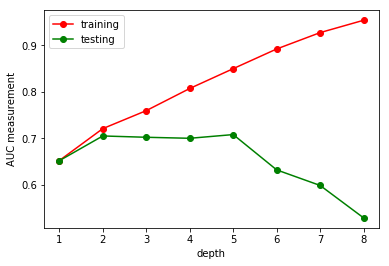

In [15]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

param_range = parameters
train_score,test_score = validation_curve(DecisionTreeClassifier(), X_train, y_train, param_name='max_depth', 
                                          param_range=param_range,cv=10,scoring='roc_auc')
train_score =  np.mean(train_score,axis=1)
test_score = np.mean(test_score,axis=1)
plt.plot(param_range,train_score,'o-',color = 'r',label = 'training')
plt.plot(param_range,test_score,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('depth')
plt.ylabel('AUC measurement')
plt.show()

### 问题
1.根据学习曲线，你能看出，depth可能在多少的时候，模型达到最优么？为什么？

2.depth为6的时候，模型是欠拟合还是过拟合呢？这时候我们通常称之为方差过大还是偏差过大？


Answer1: 能看出，因为在depth达到2之后，在training-set上的性能就下降了。

Answer2: 过拟合，方差过大。

----

### 重采样

仿佛到了现在，我们的模型效果已经可以接受了。

我们更换一个模型，用逻辑回归（LogisticRegression）来试试效果。

In [16]:
from sklearn.linear_model import LogisticRegression

lr_parameters = [0.01, 0.1, 1, 3, 5, 8, 12, 16]
# 重新定义model_name_param_dict，通常我们会将需要的尝试的模型放到一起，方便调用时取用
model_name_param_dict = {
        'DT': (DecisionTreeClassifier(),
                {'max_depth': parameters}),
        'LR': (LogisticRegression(),
                {'C': lr_parameters}),
                         }

# TODO
# 调用optimize_train_test_model重新训练，模型及参数为以上model_name_param_dict中所定义的逻辑回归模型LogisticRegression,同样存储到gscv中
gscv = optimize_train_test_model(X_train, y_train, X_test, y_test,'LR',model_name_param_dict['LR'][0],model_name_param_dict['LR'][1])

训练LR中
训练AUC：0.900
测试AUC：0.861
最优参数：{'C': 1}
训练模型耗时: 1.2547s
###########################################


你在测试集上应该看到了一个大于0.8的AUC值，这看起来已经是很理想的一个模型了。（LR模型运算耗时要比DT高，而且，如果在数据没有进行归一化时耗时高的特点会更明显，大家可以自行尝试）

但是，让我们再仔细思考在这个案例中，我们所面对的这份数据。

In [17]:
# TODO
# 计算一下训练集y_train中有离职数据（为1）的比例是多少
attrition_num = np.sum(y_train)

print("离职数据比列：{}".format(attrition_num/len(y_train)))

离职数据比列：0.1522108843537415


结果应该是一个在10%到20%之间的较小比例值，这是一份不均衡的训练集。一般来说，当少量样本比例在10%以下时，是必定要开始处理数据的失衡问题，这里虽未达到这么小，我们也同样尝试做下处理。

从另一个角度考虑，我们做这份数据分析的初衷，是希望识别那些有较高离职可能的员工，从而采取些行动。从结果指标判断，我们其实希望结果有较高的召回率，我们来计算一下以上模型的召回率。

**小问题：** 为何我们这里关注的是召回率？

召回率是在预测为1的那些样本中实际为1的比例。在问题里我们希望尽可能预测出‘1’：也就是要离职的员工，希望结果准确，所以希望预测的这些1都是真的才合胃口。那么就要提高recall。

In [18]:
from sklearn.metrics import recall_score

def calculate_recall(y_true, y_pred):
    # TODO
    # 调用recall_score计算模型的召回率并存储到变量recall中
    recall = recall_score(y_true,y_pred)
    
    return recall

print('召回率：{}'.format(calculate_recall(y_test, gscv.best_estimator_.predict(X_test))))

召回率：0.3793103448275862


结果应该是一个比较让人失望的数字。

通常使用重采样技术来解决数据失衡的问题，其中包括向上采样以及向下采用两种方法。

首先我们通过在从多数类中随机删除实例的方法，实践一下向下采样。

#### 向下采样

在我们的数据中，分类0的数据比分类1多，向下采样即将分类0的数据量缩减到跟分类1相等

In [19]:
# 将X_train以及y_train重新拼接，便于采样处理
attrition_wait_for_sampling = pd.concat([X_train, y_train], axis = 1)

# TODO
# 获取0类数据个数，存入变量count_class_0，获取1类数据个数，存入变量count_class_1
count_class_1 = np.sum(y_train)
count_class_0 = len(y_train)-count_class_1

print("0类数据个数：{}".format(count_class_0))
print("1类数据个数：{}".format(count_class_1))

# 将训练数据attrition_wait_for_sampling分成attrition_class_0以及attrition_class_1两部分
attrition_class_0 = attrition_wait_for_sampling[attrition_wait_for_sampling['Attrition'] == 0]
attrition_class_1 = attrition_wait_for_sampling[attrition_wait_for_sampling['Attrition'] == 1]


0类数据个数：997
1类数据个数：179


In [20]:
# TODO
# 从attrition_class_0中随机抽样并复制出新项，一共取出count_class_1个，生成由count_class_1个元素组成的新数据attrition_class_0_under
idx = np.arange(len(attrition_class_0))
np.random.shuffle(idx)
idx_ = idx[0:179]
attrition_class_0_under = attrition_class_0.iloc[idx_]
# 将attrition_class_0_under与attrition_class_1进行拼接，成为新的训练数据
attrition_data_under = pd.concat([attrition_class_0_under, attrition_class_1], axis=0)
# 重新取出训练数据及目标列
y_train_under = attrition_data_under['Attrition']
X_train_under = attrition_data_under.drop(['Attrition'], axis=1)

# 训练
gscv = optimize_train_test_model(X_train_under, y_train_under, X_test, y_test,
                                         'LR', model_name_param_dict['LR'][0], model_name_param_dict['LR'][1])

# TODO
# 计算训练所得模型的召回率
print('召回率：{}'.format(calculate_recall(y_test, gscv.best_estimator_.predict(X_test))))

训练LR中
训练AUC：0.824
测试AUC：0.684
最优参数：{'C': 0.1}
训练模型耗时: 0.6949s
###########################################
召回率：0.7758620689655172


#### 向上采样
在我们的数据中，分类0的数据比分类1多，向上采样即将分类1的数据量随机增加到跟分类0相等。

In [21]:
attrition_class_1_over = pd.concat([attrition_class_1.iloc[2],attrition_class_1.iloc[3]],axis=1)
attrition_class_1_over.transpose()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,Attrition
636,-0.210661,-1.667161,1.950552,1.061787,0.0,-0.239051,1.169781,1.481551,0.379672,-0.961486,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
495,-1.086676,1.530881,-0.887515,-1.868426,0.0,-0.594639,0.254625,0.940280,0.379672,-0.961486,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [22]:
# TODO
# 从attrition_class_1中随机抽样并复制出新项，一共取出count_class_0个，生成由count_class_0个元素组成的新数据attrition_class_1_over
'''
np.random.seed()
attrition_class_1_over = None
for i in range(count_class_0):
    idx = np.random.randint(0,count_class_1-1)
    attrition_class_1_over = pd.concat([attrition_class_1_over,attrition_class_1.iloc[idx]],axis=1)
    attrition_class_1_over = attrition_class_1_over.transpose()
print(attrition_class_1_over)
'''
attrition_class_1_over = attrition_class_1.sample(count_class_0, replace=True)
# 将attrition_class_1_over与attrition_class_0进行拼接，成为新的训练数据
attrition_data_over = pd.concat([attrition_class_0, attrition_class_1_over], axis=0)
print(attrition_data_over.head())
# 重新取出训练数据及目标列
y_train_over = attrition_data_over['Attrition']
X_train_over = attrition_data_over.drop(['Attrition'], axis=1)
print(X_train_over.head())
# 训练
gscv = optimize_train_test_model(X_train_over, y_train_over, X_test, y_test,
                                                 'LR', model_name_param_dict['LR'][0], model_name_param_dict['LR'][1])

# TODO
# 计算训练所得模型的召回率，并打印出来
print('召回率：{}'.format(calculate_recall(y_test, gscv.best_estimator_.predict(X_test))))

             0         1         2         3    4         5         6  \
163   2.198380 -1.161424  1.827158 -0.891688  0.0 -1.332402  0.254625   
47    0.008343 -0.977970  1.210187 -0.891688  0.0 -1.601585 -0.660531   
98    2.307882 -0.298696  0.099639  1.061787  0.0 -1.485271  1.169781   
942  -0.101159 -1.183736  0.099639  1.061787  0.0  0.477111  1.169781   
1226 -0.539166 -0.539169  0.099639  0.085049  0.0  1.155055 -1.575686   

             7         8         9  ...   46   47   48   49   50   51   52  \
163   0.841867  1.785511  0.845911  ...  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
47    0.349801  0.379672 -0.961486  ...  1.0  0.0  0.0  0.0  1.0  0.0  1.0   
98   -1.421633  0.379672  1.749610  ...  0.0  1.0  0.0  0.0  0.0  1.0  1.0   
942  -0.142264  0.379672  0.845911  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0   
1226 -0.486709  0.379672 -0.961486  ...  1.0  0.0  0.0  0.0  1.0  0.0  1.0   

       53   54  Attrition  
163   0.0  1.0          0  
47    1.0  0.0          0  
98    1.

到目前为止，你所能看到的结果应该已经是个效果相当不错的模型了，AUC以及召回率都达到我们所期望的效果。

### 选修

对于重采样操作，我们如上随机复制数据的方式并不是科学的方法。看似简单，可天下没有免费的午餐。

当随机复制数据并做上采样时，出现了大量重复数据，因为我们刻意强调了某些数据特点，会出现过拟合的可能。

当随机删除大类样本中的数据时，由于删除操作的随意性，有可能会使得大类样本中的某些信息被删除掉从而影响模型效果。

Python [`imbalanced-learn模块`](http://contrib.scikit-learn.org/imbalanced-learn/stable/)提供了更为丰富和科学的重采样方法，比如在做下采样时，先对大类样本做聚类操作，然后从每个聚类中均匀删除记录以便尽可能保留大类样本中的有用信息。又比如在做上采样的时候，不是简单的做记录复制，而是在复制出的记录属性中，加入一些小的偏差值，以保证数据多样性的原本特点。

我们可以在conda命令行中执行 conda install -c conda-forge imbalanced-learn ，来安装这个模块。

以下代码中，我们尝试使用imblearn.combine.SMOTETomek来做上下采样相结合的数据处理，然后进行模型训练并查看结果。（在imblearn模块中，还存在其它如imblearn.over_sampling.SMOTE、imblearn.under_sampling.ClusterCentroids等多种上采样或者下采样方法）

In [23]:
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier

# TODO
# 构建SMOTETomek对象smt并将ratio设置为auto
smt = None

# 对数据进行采样处理并生成到X_smt和y_smt中
X_smt, y_smt = smt.fit_sample(X_train, y_train)

# TODO
# 调用optimize_train_test_model使用LR算法对数据进行训练
gscv = None

# TODO
# 计算训练所得模型的召回率
print('召回率：{}'.format(None))

ModuleNotFoundError: No module named 'imblearn'